In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft, fftfreq, rfft, rfftfreq, fftshift, ifftshift
from scipy import signal
from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings('ignore')


import pandas as pd
import pickle
import json

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import seaborn as sns

import scipy.signal as signal
from scipy.fft import fft

sns.set_theme(style = 'white')
mpl.rc('xtick.minor', visible = True)
mpl.rc('ytick.minor', visible = True)
mpl.rc('xtick', direction='in', top=True, bottom = True)
mpl.rc('ytick', direction='in', right=True, left = True)

In [2]:
def preprocess_dataframe(df):

    # Create lists to store processed data
    scans = []
    signal_list = []
    time_signal_ns_list = []
    waveform_list = []
    time_waveform_ns_list = []
    time_stamp_signal_list = []
    time_stamp_waveform_list = []
    
    # Process each row
    for idx, row in df.iterrows():
        scan = row['scan']
        scans.append(scan)
        
        # Process signal data
        signal = np.array(row['signal'])
        time_windowed_signal = np.array(row['time_signal'])
        

        # Convert time to start from 0 and convert to ns
        time_start = time_windowed_signal[0]
        processed_time_signal = (time_windowed_signal - time_start)
        
        # Process waveform data
        waveform = np.array(row['waveform'])
        time_windowed_waveform = np.array(row['time_waveform'])
        
        
        # Convert time to start from 0 and convert to ns
        time_start_wf = time_windowed_waveform[0]
        processed_time_waveform = (time_windowed_waveform - time_start_wf)  
        
        # Store processed data in lists
        signal_list.append(signal.tolist())
        time_signal_ns_list.append(processed_time_signal.tolist())
        waveform_list.append(waveform.tolist())
        time_waveform_ns_list.append(processed_time_waveform.tolist())
        time_stamp_signal_list.append(row['time_stamp_signal'])
        time_stamp_waveform_list.append(row['time_stamp_waveform'])
    
    # Create a new DataFrame all at once
    processed_df = pd.DataFrame({
        'scan': scans,
        'time_stamp_signal': time_stamp_signal_list,
        'signal': signal_list,
        'time_signal': time_signal_ns_list,
        'time_stamp_waveform': time_stamp_waveform_list,
        'waveform': waveform_list,
        'time_waveform': time_waveform_ns_list,
    })
    
    return processed_df

#-------------------------------------------------------------------------------------------------------------------

def sigmoid(t, A, k, t0, B):
    return A / (1 + np.exp(-k * (t - t0))) + B

#-------------------------------------------------------------------------------------------------------------------

def sort_by_waveform_amplitude(processed_df):
    # Create a copy of the processed DataFrame
    sorted_df = processed_df.copy()
    
    # List to store the amplitude values
    amplitudes = []
    var_amplitudes = []
    
    # Fit sigmoid to each waveform and extract the amplitude
    for idx, row in processed_df.iterrows():
        waveform = np.array(row['waveform'])
        time = np.array(row['time_waveform'])
        
        try:
            # Initial parameter guesses
            # A: estimate from max-min of waveform
            # k: moderate steepness
            # t0: midpoint of time range
            # B: minimum value of waveform
            p0 = [
                np.max(waveform) - np.min(waveform),  # A: amplitude guess
                0.1,                                   # k: steepness guess
                np.median(time),                       # t0: midpoint guess
                np.min(waveform)                       # B: offset guess
            ]
            
            # Set bounds to help convergence
            bounds = (
                [0, 0, np.min(time), -np.inf],          # Lower bounds
                [np.inf, np.inf, np.max(time), np.inf]  # Upper bounds
            )
            
            # Perform the fit
            popt, pcov = curve_fit(sigmoid, time, waveform, p0=p0, bounds=bounds, maxfev=10000)
            
            # Extract the amplitude (parameter A)
            amplitude = popt[0]
            amplitude_var = pcov[0][0]
            
        except Exception as e:
            print(f"Fitting failed for scan {row['scan']}: {e}")
            # Assign a default amplitude if fitting fails
            amplitude = 0
            amplitude_var = 0
        
        amplitudes.append(amplitude)
        var_amplitudes.append(amplitude_var)
    
    # Add the amplitude and variance columns to the DataFrame
    sorted_df['waveform_amplitude'] = amplitudes
    sorted_df['waveform_amplitude_var'] = var_amplitudes
    
    # Sort the DataFrame by amplitude
    sorted_df = sorted_df.sort_values(by='waveform_amplitude')
    
    # Reset the index
    sorted_df = sorted_df.reset_index(drop=True)
    
    return sorted_df

#-------------------------------------------------------------------------------------------------------------------

def reconstruct_energy_deposition(input_signal, dt):
    ADC_to_V = 0.13/(20e3)
    offset = np.mean(input_signal[:int(len(input_signal)*0.2)]) 
    output_signal = np.zeros_like(input_signal)
    effective_signal = (input_signal - offset) * ADC_to_V  

    for i in range(1, len(input_signal)):
        input_contribution = (effective_signal[i] + effective_signal[i-1]) * dt / 2 
        output_signal[i] = output_signal[i-1] + input_contribution
    
    return output_signal * 1e15 # output in eV

#-------------------------------------------------------------------------------------------------------------------



#-------------------------------------------------------------------------------------------------------------------

def compute_magnitude(fft_input):
    N = len(fft_input)
    magnitude = np.abs(fft_input[:int(N/2)]) * 2 / N
    magnitude[0] /= 2  
    return magnitude

In [39]:
# crate a list of files names
data_path = '/Users/raffaelegaudio/JFET_model/energy_scans_pulser/'

signals = []
waveforms = []

for id in range(14):
    signal_file = data_path+'pulser_signal_p11_r006_'+str(id)+'.json' 
    signals.append(signal_file)

for id in range(14):
    waveform = data_path+'mean_pulser_wf_all_ICPC_p11_r006_'+str(id)+'.json' 
    waveforms.append(waveform)


# create dictionaries to store the data
signal_data = {}
waveform_data = {}

for i, file_path in enumerate(signals):
    with open(file_path, 'r') as file:
        signal_data[f'scan_{i}'] = json.load(file)

for i, file_path in enumerate(waveforms):
    with open(file_path, 'r') as file:
        waveform_data[f'scan_{i}'] = json.load(file)


# create a dataframe with all the data
df_data = []

for i in range(14):
    row_data = {
        'scan': i,
        'time_stamp_signal': signal_data[f'scan_{i}']['time_stamp'],
        'signal': signal_data[f'scan_{i}']['signal'],
        'time_signal': signal_data[f'scan_{i}']['time_windowed'],

    }

    row_data['time_stamp_waveform'] = waveform_data[f'scan_{i}']['time_stamp'] 
    row_data['waveform'] = waveform_data[f'scan_{i}']['signal']
    row_data['time_waveform'] = waveform_data[f'scan_{i}']['time_windowed']

    df_data.append(row_data)

# Create the DataFrame
df = pd.DataFrame(df_data)
processed_df = preprocess_dataframe(df)

# Attenuation factors-----------------------------------------------------------------------------------
def ratio(attenaution_db):
    return 10**(-attenaution_db/20.0)

attenuations_db = np.array([52,42,38,35,32,28,26,24,23,21,20,19,18,17])
ratios = np.array([ratio(i) for i in attenuations_db])


# Sort by waveform amplitue and apply attenuation function
sorted_df = sort_by_waveform_amplitude(processed_df)
pulser_df_ADC = sorted_df.copy()

# Before applying the attenuation, we need to remove the offset from the signal
# We take as offset value the first 20% of the signal
offset_idx = int(len(sorted_df['signal'][0]) * 0.2)

# Apply the scaling to each row
for i in range(len(ratios)):
    if i < len(pulser_df_ADC) and i < len(ratios):
        offset = np.mean(pulser_df_ADC.at[i, 'signal'][:offset_idx])                                    # evaluate offset
        pulser_df_ADC.at[i, 'signal'] = [val - offset for val in pulser_df_ADC.at[i, 'signal']]         # remove offset
        pulser_df_ADC.at[i, 'signal'] = [val * ratios[i] for val in pulser_df_ADC.at[i, 'signal']]      # apply attenuation factor
        pulser_df_ADC.at[i, 'signal'] = [val + offset for val in pulser_df_ADC.at[i, 'signal']]         # apply offset back 


pulser_df_ADC = pulser_df_ADC[:-3] # remove the last 3 scans (saturation)

pulser_df_ADC

,scan,time_stamp_signal,signal,time_signal,time_stamp_waveform,waveform,time_waveform,waveform_amplitude,waveform_amplitude_var
0,12,1.716273e+09,"[14964.736378141415, 14964.741401914278, 14964...","[0.0, 16.011436740525824, 32.02287348105892, 4...",1.716273e+09,"[15821, 15820, 15819, 15818, 15820, 15813, 158...","[0.0, 16.011436740525824, 32.02287348105892, 4...",713.502667,0.358019
1,1,1.716273e+09,"[14965.922795441442, 14965.827476053275, 14965...","[0.0, 16.011436740525824, 32.02287348105892, 4...",1.716273e+09,"[15726, 15725, 15725, 15727, 15725, 15727, 157...","[0.0, 16.011436740525824, 32.02287348105892, 4...",2233.032399,3.174474
2,2,1.716273e+09,"[14965.50276816011, 14965.490178905991, 14965....","[0.0, 16.011436740525824, 32.02287348105892, 4...",1.716273e+09,"[15754, 15751, 15756, 15757, 15755, 15758, 157...","[0.0, 16.011436740525824, 32.02287348105892, 4...",3524.535605,7.700935
3,8,1.716272e+09,"[14964.884968289862, 14964.742705937058, 14964...","[0.0, 16.011436740525824, 32.02287348105892, 4...",1.716272e+09,"[15795, 15794, 15789, 15790, 15791, 15788, 157...","[0.0, 16.011436740525824, 32.02287348105892, 4...",4989.356879,15.142610
4,5,1.716272e+09,"[14958.52275212591, 14958.62322758317, 14958.6...","[0.0, 16.011436740525824, 32.02287348105892, 4...",1.716272e+09,"[15894, 15896, 15891, 15892, 15894, 15894, 158...","[0.0, 16.011436740525824, 32.02287348105892, 4...",7024.002185,33.527276
5,13,1.716272e+09,"[14964.714623719543, 14965.033109455986, 14964...","[0.0, 16.011436740525824, 32.02287348105892, 4...",1.716272e+09,"[15932, 15937, 15937, 15935, 15935, 15933, 159...","[0.0, 16.011436740525824, 32.02287348105892, 4...",11154.952539,79.948746
6,3,1.716272e+09,"[14965.83825232205, 14965.387183811785, 14965....","[0.0, 16.011436740525824, 32.02287348105892, 4...",1.716272e+09,"[15728, 15725, 15730, 15732, 15734, 15730, 157...","[0.0, 16.011436740525824, 32.02287348105892, 4...",14035.834533,130.877064
7,7,1.716272e+09,"[14961.404396574042, 14961.46749230849, 14961....","[0.0, 16.011436740525824, 32.02287348105892, 4...",1.716272e+09,"[15809, 15810, 15812, 15813, 15816, 15820, 158...","[0.0, 16.011436740525824, 32.02287348105892, 4...",17636.096877,207.490468
8,10,1.716271e+09,"[14963.278755551142, 14963.137166394265, 14962...","[0.0, 16.011436740525824, 32.02287348105892, 4...",1.716271e+09,"[15711, 15708, 15708, 15707, 15710, 15709, 157...","[0.0, 16.011436740525824, 32.02287348105892, 4...",19793.077590,245.216651
9,9,1.716271e+09,"[14967.231590910125, 14967.0533407225, 14967.4...","[0.0, 16.011436740525824, 32.02287348105892, 4...",1.716271e+09,"[15904, 15906, 15906, 15901, 15900, 15902, 159...","[0.0, 16.011436740525824, 32.02287348105892, 4...",24879.401406,373.502719


freq analysis functions

In [4]:
def compute_fft(time_signal, sampling_rate, real_only=True):

    signal = np.array(time_signal)
    N = len(signal)
    fs = sampling_rate  

    if real_only:
        # For real signals, use rfft (more efficient)
        fft_vals = rfft(signal)
        freqs = rfftfreq(N, 1/fs)
        # Magnitude spectrum (normalized)
        magnitude = np.abs(fft_vals) * 2/N
        magnitude[0] /= 2  # DC component shouldn't be doubled
        if N % 2 == 0:
            magnitude[-1] /= 2  # Nyquist frequency
    else:
        # Full complex FFT
        fft_vals = fft(signal)
        freqs = fftfreq(N, 1/fs)
        # Get positive frequencies only
        pos_mask = freqs >= 0
        freqs = freqs[pos_mask]
        magnitude = np.abs(fft_vals[pos_mask]) * 2/N
    
    # Phase spectrum
    phase = np.angle(fft_vals)
    
    return fft_vals, freqs, magnitude, phase

In [27]:
data_time = pulser_df_ADC['time_signal'][0]
dt = (data_time[1] - data_time[0])*1e-9  # Sampling interval in seconds


signal_fft_vals = np.zeros((11,1400)).astype(complex)
signal_freqs = np.zeros((11,700)).astype(complex)
signal_magnitude = np.zeros((11,700)).astype(complex)


waveforms_fft_vals = np.zeros((11,1400)).astype(complex)
waveform_freqs = np.zeros((11,700)).astype(complex)
waveform_magnitude = np.zeros((11,700)).astype(complex)

fft_ratios_waveform_signal = np.zeros((11,1400)).astype(complex)


wf_offset_indx = int(len(pulser_df_ADC['waveform'][0]) * 0.2)

for k in range(11):
    signal_fft_vals[k,:], signal_freqs[k,:], signal_magnitude[k,:], _ = compute_fft((pulser_df_ADC['signal'][k]-np.mean(pulser_df_ADC['signal'][k][:wf_offset_indx])), 1/dt, real_only=False)
    waveforms_fft_vals[k,:], waveform_freqs[k,:], waveform_magnitude[k,:], _ = compute_fft((pulser_df_ADC['waveform'][k]-np.mean(pulser_df_ADC['waveform'][k][:wf_offset_indx])), 1/dt, real_only=False)
    fft_ratios_waveform_signal[k,:] = fft(pulser_df_ADC['waveform'][k]-np.mean(pulser_df_ADC['waveform'][k][:wf_offset_indx]))/fft(pulser_df_ADC['signal'][k]-np.mean(pulser_df_ADC['signal'][k][:wf_offset_indx]))

filtr=np.mean(fft_ratios_waveform_signal, axis=0)

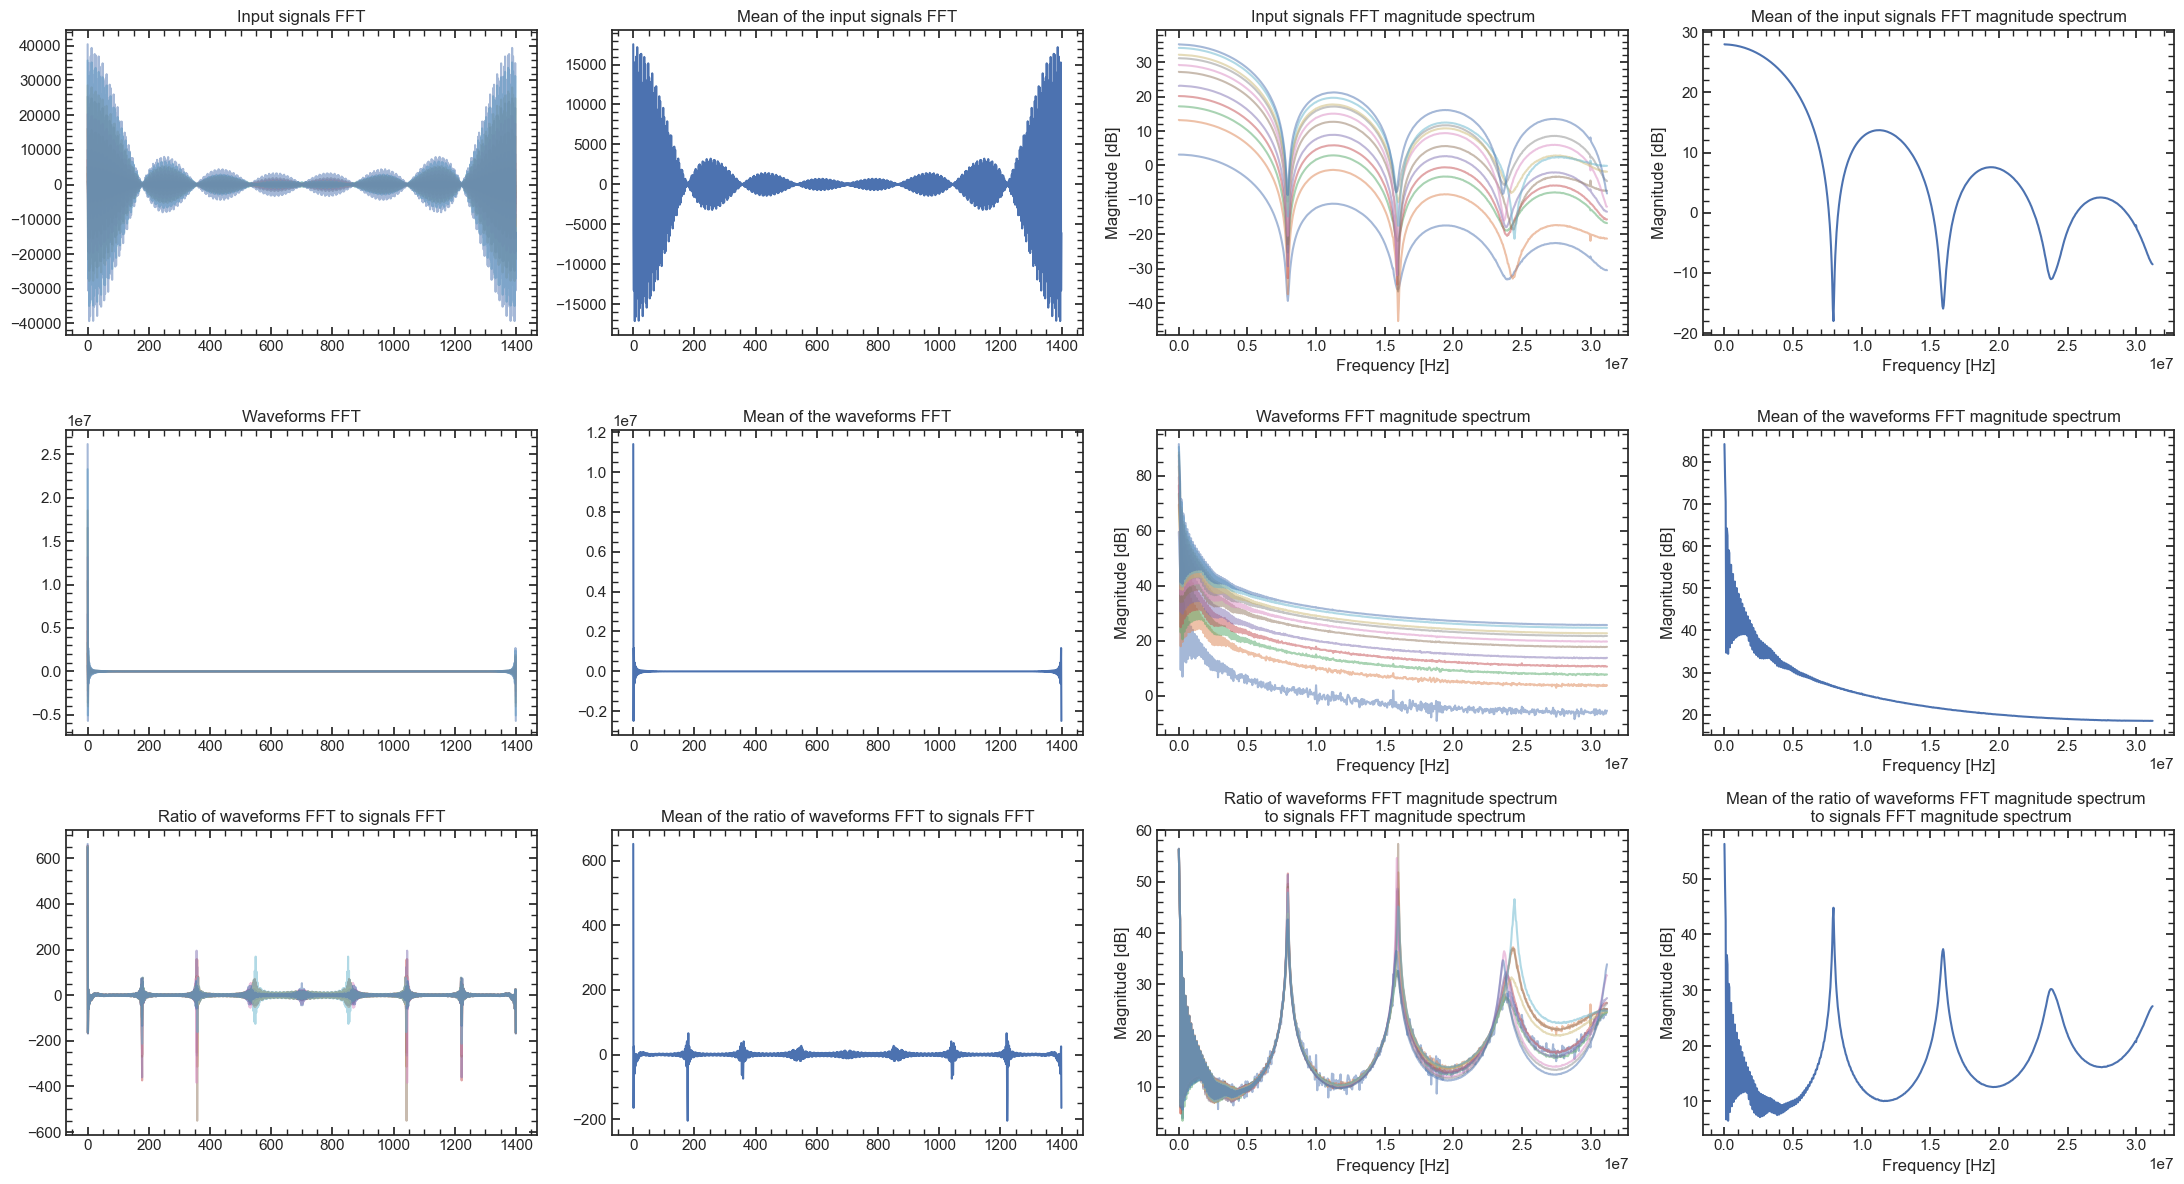

In [30]:
plt.figure(figsize=(22, 12))

plt.subplot(3, 4, 1)
plt.title('Input signals FFT')
for i in range(11):
    plt.plot(signal_fft_vals[i,:], label=f'signal {i+1}', alpha=0.5)

plt.subplot(3, 4, 2)
plt.title('Mean of the input signals FFT')
plt.plot(np.mean(signal_fft_vals, axis=0))

plt.subplot(3, 4, 3)
plt.title('Input signals FFT magnitude spectrum')
for i in range(11):
    plt.plot(signal_freqs[i,:], 20*np.log10(signal_magnitude[i,:]), label=f'signal {i+1}', alpha=0.5)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude [dB]')

plt.subplot(3, 4, 4)
plt.title('Mean of the input signals FFT magnitude spectrum')
plt.plot(signal_freqs[0], 20*np.log10(np.mean(signal_magnitude, axis=0)))
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude [dB]')

plt.subplot(3, 4, 5)
plt.title('Waveforms FFT')
for i in range(11):
    plt.plot(waveforms_fft_vals[i,:], alpha=0.5, label=f'waveform {i+1}')

plt.subplot(3, 4, 6)
plt.title('Mean of the waveforms FFT')
plt.plot(np.mean(waveforms_fft_vals, axis=0))

plt.subplot(3, 4, 7)
plt.title('Waveforms FFT magnitude spectrum')
for i in range(11):
    plt.plot(waveform_freqs[i,:], 20*np.log10(waveform_magnitude[i,:]), label=f'signal {i+1}', alpha=0.5)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude [dB]')

plt.subplot(3, 4, 8)
plt.title('Mean of the waveforms FFT magnitude spectrum')
plt.plot(waveform_freqs[0], 20*np.log10(np.mean(waveform_magnitude, axis=0)))
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude [dB]')

plt.subplot(3, 4, 9)
plt.title('Ratio of waveforms FFT to signals FFT')
for i in range(11):
    plt.plot(fft_ratios_waveform_signal[i,:], label=f'signal {i+1}', alpha=0.5)

plt.subplot(3, 4, 10)
plt.title('Mean of the ratio of waveforms FFT to signals FFT')
plt.plot(np.mean(fft_ratios_waveform_signal, axis=0))

plt.subplot(3, 4, 11)
plt.title('Ratio of waveforms FFT magnitude spectrum \n to signals FFT magnitude spectrum')
for i in range(11):
    plt.plot(signal_freqs[i,:], 20*np.log10(waveform_magnitude[i,:]) - 20*np.log10(signal_magnitude[i,:]), label=f'signal {i+1}', alpha=0.5)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude [dB]')

plt.subplot(3, 4, 12)
plt.title('Mean of the ratio of waveforms FFT magnitude spectrum \n to signals FFT magnitude spectrum')
plt.plot(signal_freqs[0], 20*np.log10(np.mean(waveform_magnitude, axis=0)) - 20*np.log10(np.mean(signal_magnitude, axis=0)))
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude [dB]')

plt.tight_layout();


-------

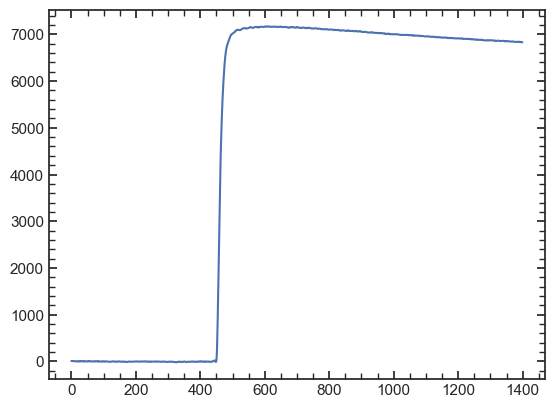

In [9]:
plt.plot(ifft(fft(pulser_df_ADC['signal'][4]-np.mean(pulser_df_ADC['signal'][4][:wf_offset_indx]))*(fft(pulser_df_ADC['waveform'][4]-np.mean(pulser_df_ADC['waveform'][4][:wf_offset_indx]))/fft(pulser_df_ADC['signal'][4]-np.mean(pulser_df_ADC['signal'][4][:wf_offset_indx])))))

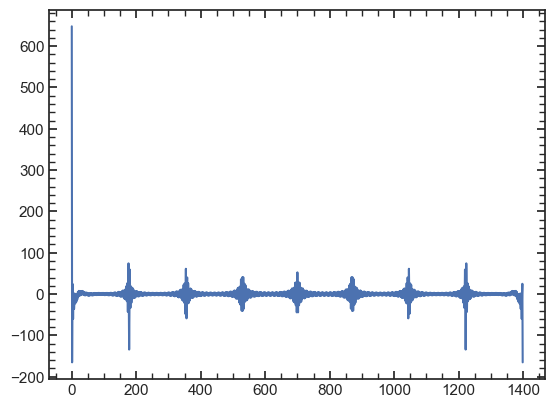

In [10]:
plt.plot(fft(pulser_df_ADC['waveform'][10]-np.mean(pulser_df_ADC['waveform'][10][:wf_offset_indx]))/fft(pulser_df_ADC['signal'][10]-np.mean(pulser_df_ADC['signal'][10][:wf_offset_indx])))

In [11]:
print((fft(pulser_df_ADC['waveform'][4]-np.mean(pulser_df_ADC['waveform'][4][:wf_offset_indx]))/fft(pulser_df_ADC['signal'][4]-np.mean(pulser_df_ADC['signal'][4][:wf_offset_indx]))))

[ 6.56751254e+02  +0.j         -1.64254428e+02-212.22148639j
  2.49182936e+01-132.2221439j  ...  4.99141160e-01  +2.27954478j
  2.49182936e+01+132.2221439j  -1.64254428e+02+212.22148639j]


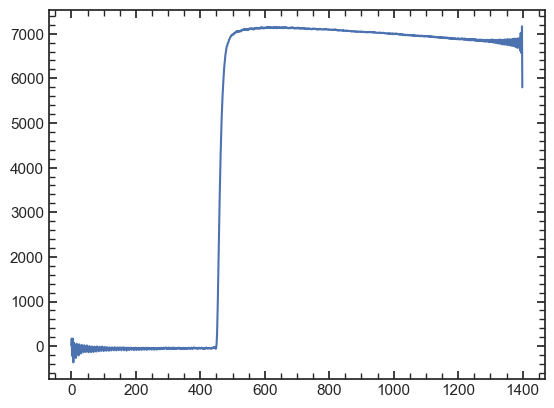

In [31]:
plt.plot(ifft(signal_fft_vals[4]*filtr))

-------

In [32]:
def fill_trailing_zeros_with_max(arr):
    result = arr.copy()
    for i, row in enumerate(result):
        max_val = np.max(row)
        
        # Find indices of non-zero elements
        nonzero_indices = np.nonzero(row)[0]
        
        if len(nonzero_indices) > 0:
            # Get the index after the last non-zero element
            last_nonzero_idx = nonzero_indices[-1]
            # Fill trailing zeros
            result[i, last_nonzero_idx + 1:] = max_val
    
    return result


def apply_padding(array, padding_length, position="left", paddign_value=0):
    padding_base = np.ones((array.shape[0], padding_length))

    if type(paddign_value) is not int and type(paddign_value) is not float: 
        if len(paddign_value) != array.shape[0]:
            raise ValueError("Padding value must match the number of columns in the array.")
        else:
            padding = (padding_base.T * paddign_value).T
    else:
        padding = padding_base * paddign_value

    if position == "left":
        return np.concatenate((padding, array), axis=1)
    elif position == "right":
        return np.concatenate((array, padding), axis=1)
    elif position == "both":
        return np.concatenate((padding, array, padding), axis=1)
    else:
        raise ValueError("Position must be 'left', 'right', or 'both'.")
    

# open the file with energy depositions
max_len = 1600
n_signals = 5

energy_depositions = np.zeros((n_signals, max_len))

dict_signals = {}

with open("/Users/raffaelegaudio/JFET_model/signals_gesim.txt", "r") as f:
    for line in f:
        kay = str(line.strip()[0:8])
        val = line.strip()[11:-1]
        dict_signals[kay] = val

for idx, kay in enumerate(dict_signals.keys()):
    tmp = dict_signals[kay]
    tmp = tmp.replace(" ", "")
    tmp = tmp.replace("eV", "")
    tmp = tmp.split(",")
    for i in range(len(tmp)):
        energy_depositions[idx, i] = float(tmp[i])


# extend the max value of the energy deposition in the original array
energy_depositions_tailed = fill_trailing_zeros_with_max(energy_depositions)

# apply padding at the beginning of the array (baseline)
padding_length_baseline = int(22400*0.2)
energy_depositions_padded = apply_padding(energy_depositions_tailed, padding_length_baseline, position="left", paddign_value=0)    # baseline

# applay padding at the end of the array (tail)
max_energy = []
for i in range(n_signals):
    max_energy.append(np.max(energy_depositions_padded[i]))
tails = np.array(max_energy) 
padding_length_tail = int(22400*0.8)
energy_depositions_padded = apply_padding(energy_depositions_padded, padding_length_tail, position="right", paddign_value=tails) # tail

dict_signals[kay] = val

for idx, kay in enumerate(dict_signals.keys()):
    tmp = dict_signals[kay]
    tmp = tmp.replace(" ", "")
    tmp = tmp.replace("eV", "")
    tmp = tmp.split(",")
    for i in range(len(tmp)):
        energy_depositions[idx, i] = float(tmp[i])


# extend the max value of the energy deposition in the original array
energy_depositions_tailed = fill_trailing_zeros_with_max(energy_depositions)

# apply padding at the beginning of the array (baseline)
padding_length_baseline = int(22400*0.2)
energy_depositions_padded = apply_padding(energy_depositions_tailed, padding_length_baseline, position="left", paddign_value=0)    # baseline

# applay padding at the end of the array (tail)
max_energy = []
for i in range(n_signals):
    max_energy.append(np.max(energy_depositions_padded[i]))
tails = np.array(max_energy) 
padding_length_tail = int(22400*0.8)
energy_depositions_padded = apply_padding(energy_depositions_padded, padding_length_tail, position="right", paddign_value=tails) # tail



In [62]:
q = 1.6e-19
W = 1
R = 10000e9

ADC_to_V = 0.13/(20e3)
V_to_ADC = 1/ADC_to_V

current = np.gradient(energy_depositions_padded, axis=1)/W * q  # in A
voltage = (current * R)
voltage = voltage[:,::16][:,:1400]

voltage_fft_vals = np.zeros((11,1400)).astype(complex)
voltage_freqs = np.zeros((11,700)).astype(complex)
voltage_magnitude = np.zeros((11,700)).astype(complex)

for i in range(voltage.shape[0]):
    voltage_fft_vals[i,:], voltage_freqs[i,:], voltage_magnitude[i,:], _ = compute_fft(voltage[i,:], 1/dt, real_only=False)
    voltage_fft_vals[i,:] = fft(voltage[i,:])

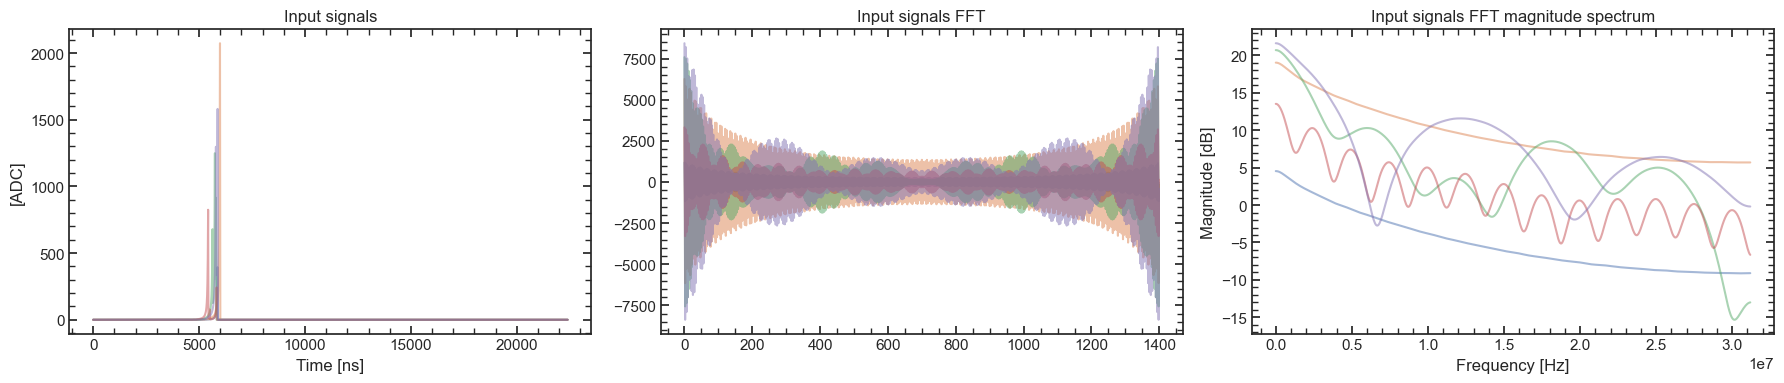

In [35]:
plt.figure(figsize=(18, 4))

for i in range(voltage.shape[0]):

    plt.subplot(1, 3, 1)
    plt.title('Input signals')
    plt.plot(data_time, voltage[i,:], label=f'signal {i+1}', alpha=0.5)
    plt.ylabel('[ADC]')
    plt.xlabel('Time [ns]')

    plt.subplot(1, 3, 2)
    plt.title('Input signals FFT')
    plt.plot(voltage_fft_vals[i,:], label=f'signal {i+1}', alpha=0.5)

    plt.subplot(1, 3, 3)
    plt.title('Input signals FFT magnitude spectrum')
    plt.plot(voltage_freqs[i,:], 20*np.log10(voltage_magnitude[i,:]), label=f'signal {i+1}', alpha=0.5)
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Magnitude [dB]')

plt.tight_layout()

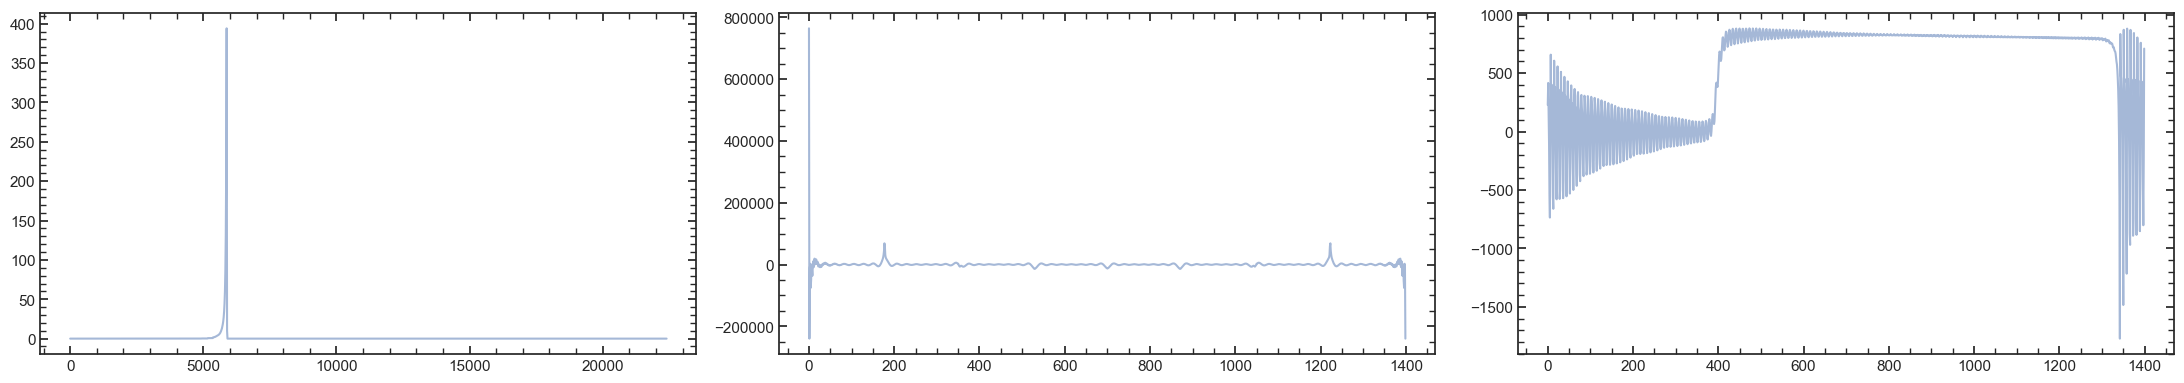

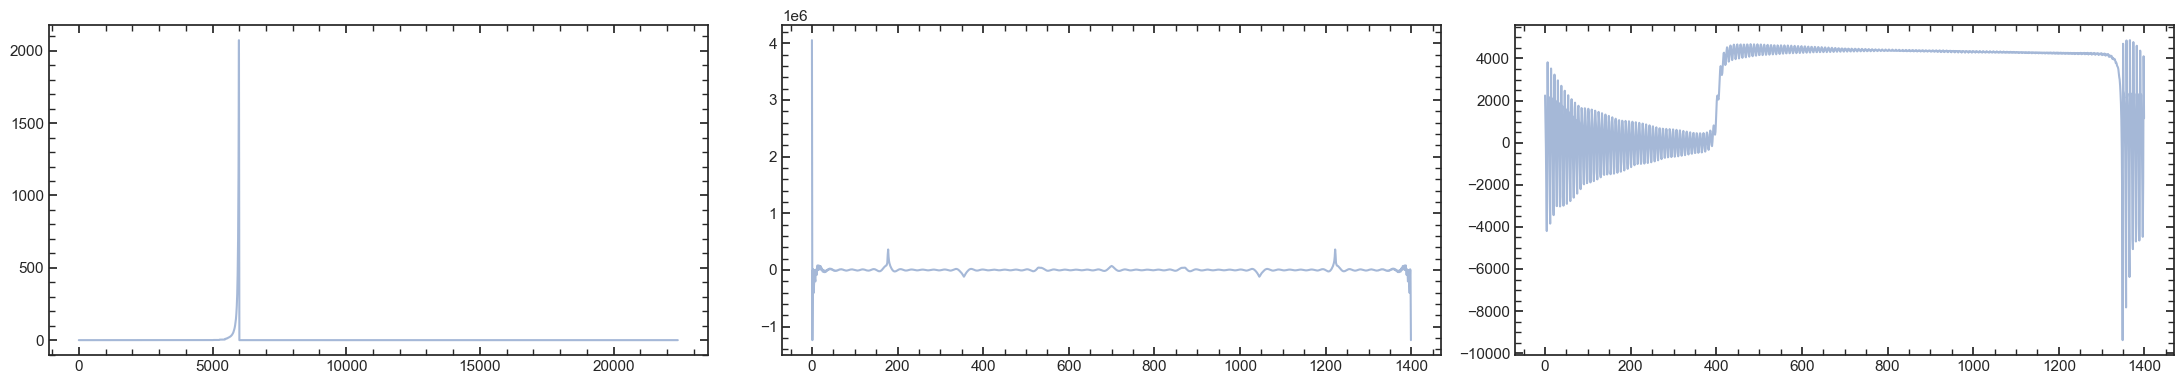

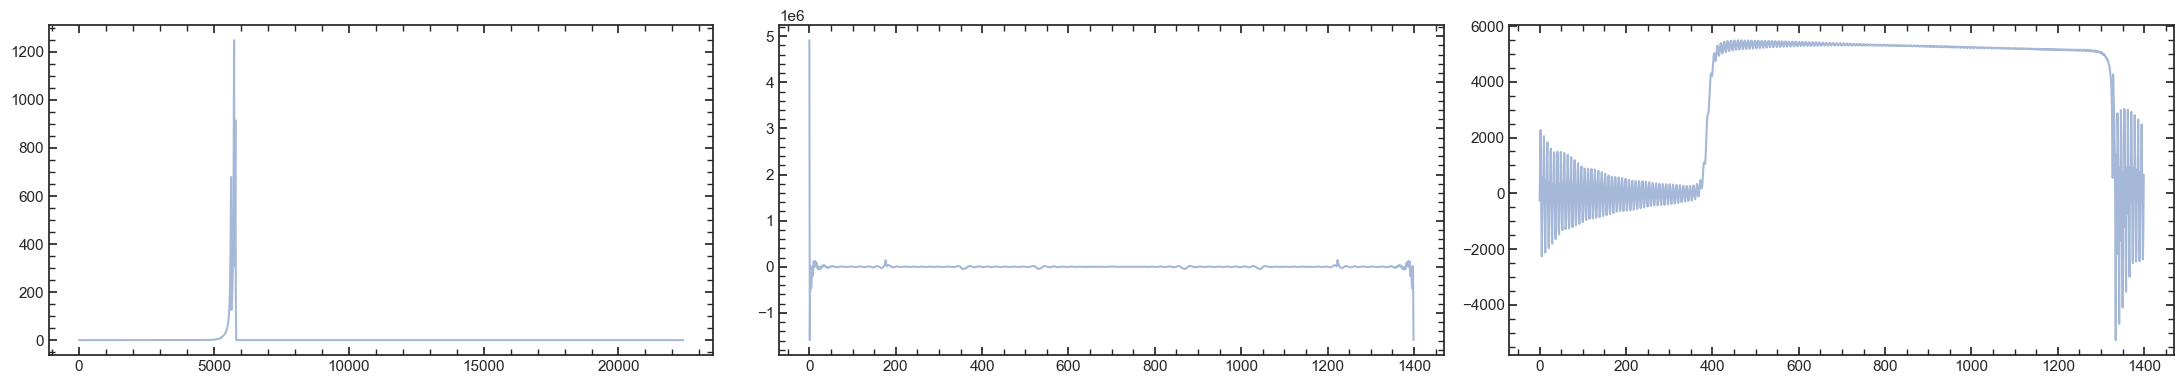

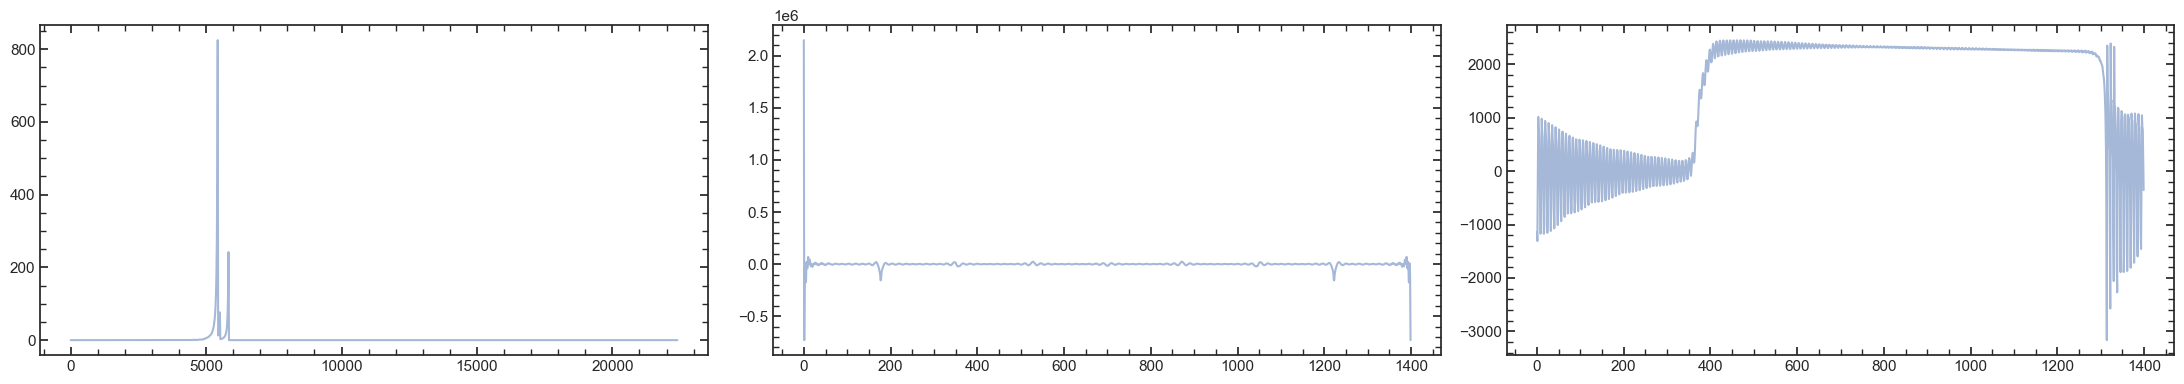

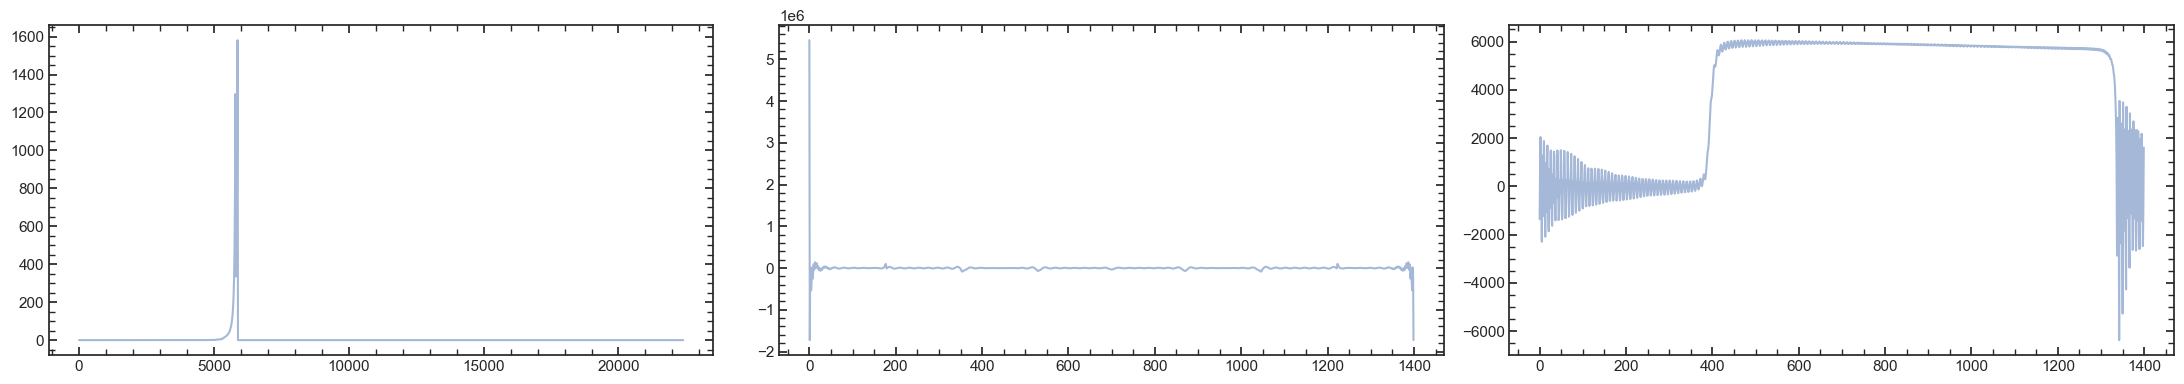

In [37]:
filtr=np.mean(fft_ratios_waveform_signal, axis=0)

for i in range(voltage.shape[0]):
    plt.figure(figsize=(22, 4))
    plt.subplot(1, 3, 1)
    plt.plot(data_time, voltage[i,:], label=f'signal {i+1}', alpha=0.5)
    
    plt.subplot(1, 3, 2)
    plt.plot(voltage_fft_vals[i,:]*fft(pulser_df_ADC['waveform'][10]-np.mean(pulser_df_ADC['waveform'][10][:wf_offset_indx]))/fft(pulser_df_ADC['signal'][10]-np.mean(pulser_df_ADC['signal'][10][:wf_offset_indx])), label=f'signal {i+1}', alpha=0.5)

    plt.subplot(1, 3, 3)
    plt.plot(ifft(voltage_fft_vals[i,:]*fft(pulser_df_ADC['waveform'][10]-np.mean(pulser_df_ADC['waveform'][10][:wf_offset_indx]))/fft(pulser_df_ADC['signal'][10]-np.mean(pulser_df_ADC['signal'][10][:wf_offset_indx]))), label=f'signal {i+1}', alpha=0.5)

    plt.tight_layout()

-----

In [79]:
normalized_wf = np.zeros((11,1400))
wf_offset_indx = int(1400*0.2)

for i in range(11):
    normalized_wf[i,:] = (pulser_df_ADC['waveform'][i]-np.mean(pulser_df_ADC['waveform'][i][:wf_offset_indx]))

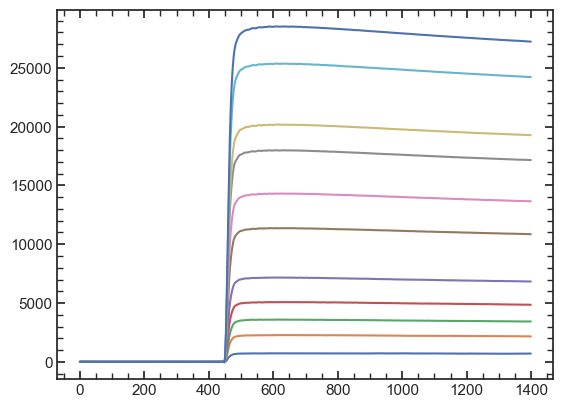

In [80]:
for i in range(11):
    plt.plot(normalized_wf[i,:])

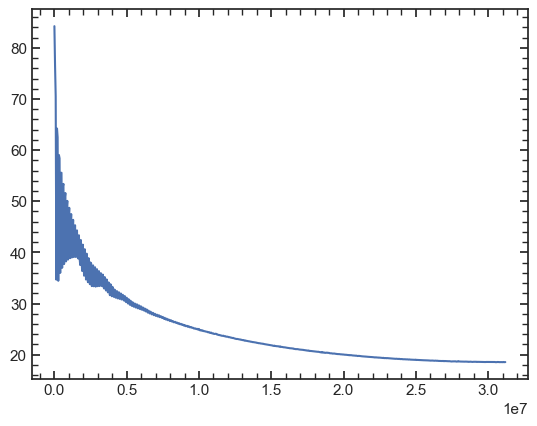

In [81]:
mean_norm_wf = np.mean(normalized_wf, axis=0)
fft_mn_wf_vals, fft_mn_wf_freq, fft_mn_wf_mag, _ = compute_fft(mean_norm_wf, 1/dt, real_only=False)

plt.plot(fft_mn_wf_freq, 20*np.log10(fft_mn_wf_mag))

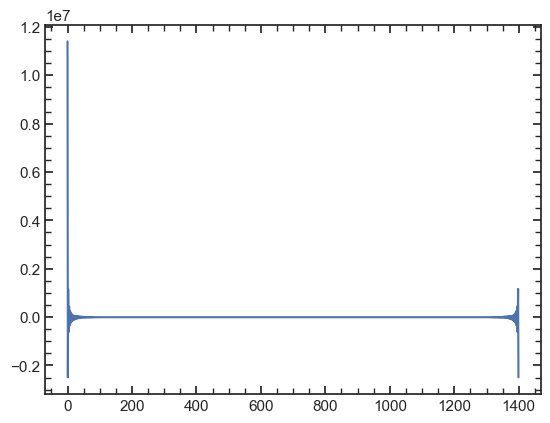

In [82]:
plt.plot(fft_mn_wf_vals)

In [74]:
def cc4(detector_signal, dt, units="ADC", add_noise=True, freq_response=True, f_h=15e6, calibration_applied=True):
    ADC_to_V = 0.13/(20e3)
    V_to_ADC = 1/ADC_to_V
    ADC_bias = 15000
    R_f = 1e9
    C_f = 400e-15
    dc_bias = -3.52
    with open('total_transfer_function_params.pkl', 'rb') as f:
        total_transfer_loaded = pickle.load(f)
    with open('calibration_curve_params.pkl', 'rb') as f:
        calibration_curve_loaded = pickle.load(f)
    
    def integrate_signal(R_f, C_f, input_signal, dt, decay=True):
        tau = R_f * C_f             
        offset = np.mean(input_signal[:int(len(input_signal)*0.2)]) 
        output_signal = np.zeros_like(input_signal)
        effective_signal = input_signal - offset  
        if decay:
            decay_factor = np.exp(-dt /tau)
        else: 
            decay_factor = 1
        for i in range(1, len(input_signal)):
            input_contribution = (effective_signal[i] + effective_signal[i-1]) * dt / (2 * C_f)
            output_signal[i] = output_signal[i-1] * decay_factor + input_contribution
        
        return -output_signal
    
    # Handle both 1D and 2D input arrays
    detector_signal = np.atleast_2d(detector_signal)
    is_1d_input = detector_signal.shape[0] == 1 and len(detector_signal.shape) == 2
    
    if freq_response:
        f_s = 62.5e6 
        low_len = 11 
        f_cut = f_h/f_s 
        filter = signal.firwin(numtaps=low_len, cutoff=f_cut, window='hamming')
    
    waveforms = np.zeros(detector_signal.shape)
    
    for i in range(detector_signal.shape[0]):
        input_signal = detector_signal[i,:] + dc_bias
        output_csa = total_transfer_loaded(input_signal)
        integrated_signal = integrate_signal(R_f, C_f, output_csa, dt, decay=True)
        
        if calibration_applied:
            conversion = calibration_curve_loaded(integrated_signal)
            waveforms[i,:] = (np.array([s*c for s,c in zip(integrated_signal, conversion)]))
        else:
            waveforms[i,:] = integrated_signal
            
        if add_noise:
            sigma = 0.0002
            noise = np.random.normal(0, sigma, detector_signal.shape[1])
            waveforms[i,:] += noise
            
        if freq_response:
            waveforms[i,:] = np.convolve(waveforms[i,:], filter)[:-low_len+1] 
    
    # Convert output units
    if units == "ADC":
        result = (waveforms * V_to_ADC) + ADC_bias    
    elif units == "V":
        result = waveforms 
    else:
        raise ValueError("Units must be 'ADC' or 'V'.")
    
    # Return 1D array if input was 1D
    if is_1d_input:
        return result[0]
    else:
        return result

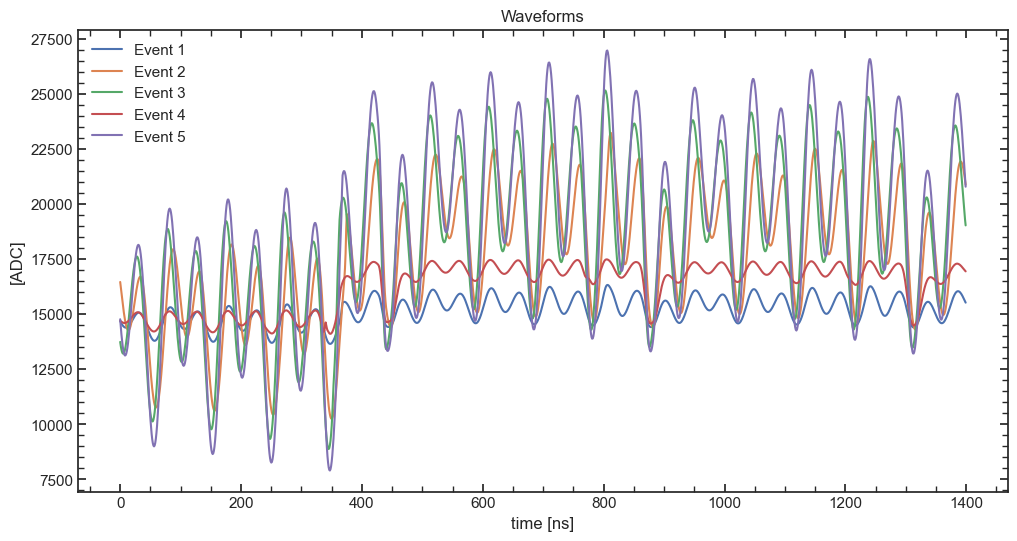

In [85]:
waveforms= cc4(voltage, dt, units="ADC", add_noise=False, freq_response=False)


plt.figure(figsize=(12, 6))  
plt.title("Waveforms")
plt.xlabel("time [ns]")
plt.ylabel("[ADC]")

for i in range(voltage.shape[0]):
    plt.plot(ifft(fft(waveforms[i])*AAAAAAA), label=f"Event {i+1}")
plt.legend(frameon=False, loc='upper left')

plt.show()

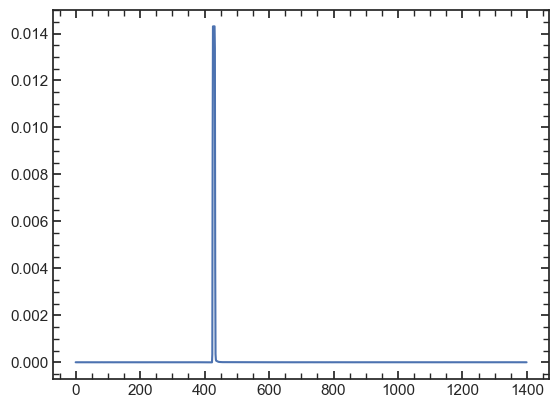

In [76]:
puls_signal = np.zeros((11,1400))

for i in range(11):
    puls_signal[i,:]=pulser_df_ADC['signal'][i]-np.mean(pulser_df_ADC['signal'][i][:int(1400*0.2)])

mean_puls_signal = np.mean(puls_signal, axis=0)*ADC_to_V

plt.plot(mean_puls_signal);

mean_simulated_wf = cc4(mean_puls_signal, dt, units='V', add_noise=False, freq_response='False')

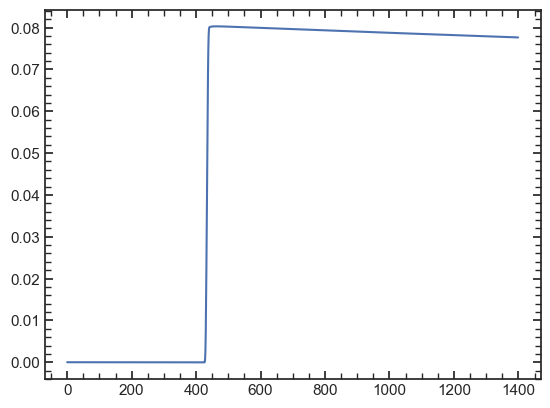

In [77]:
plt.plot(mean_simulated_wf)

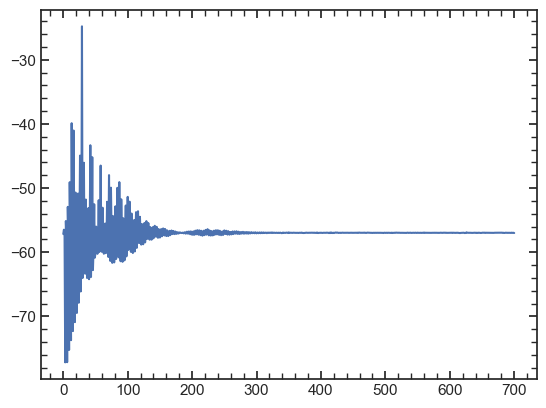

In [87]:
fft_mean_simulated_wf = fft(mean_simulated_wf)

AAAAAAA = fft_mn_wf_vals/(fft_mean_simulated_wf*V_to_ADC)

plt.plot(20*np.log10(AAAAAAA/ len(AAAAAAA)*2)[:int(len(AAAAAAA)/2 + 1)])